In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
import statsmodels.api as sm
import statsmodels.formula.api as smf

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

## Cell 2: Load the Dataset
Description: Load the 'gorilla_tug_of_war.csv' file into a pandas DataFrame.

In [2]:
df = pd.read_csv('gorilla_tug_of_war.csv')
print("Dataset loaded successfully.")

# Rename 'FRC' to 'FRM' for consistency with project description
if 'FRC' in df.columns:
    df.rename(columns={'FRC': 'FRM'}, inplace=True)
    print("Renamed column 'FRC' to 'FRM'.")

print("\nShape of dataset before cleaning:", df.shape)
print("Descriptive stats before cleaning (AGE, WHT):")
print(df[['AGE', 'WHT']].describe())

# Data Cleaning based on user feedback and PDF analysis
# 1. Remove AGE < 0 
initial_rows = len(df)
df = df[df['AGE'] >= 0]
rows_removed_age = initial_rows - len(df)
if rows_removed_age > 0:
    print(f"\nRemoved {rows_removed_age} rows with AGE < 0.")

# 2. Handle WHT outliers (
initial_rows = len(df)
# A more robust way could be IQR: Q3 + 1.5*IQR. 
df = df[df['WHT'] <= 350] 
rows_removed_wht = initial_rows - len(df)
if rows_removed_wht > 0:
    print(f"Removed {rows_removed_wht} rows with WHT > 350 kg.")

print("\nShape of dataset after cleaning:", df.shape)


Dataset loaded successfully.
Renamed column 'FRC' to 'FRM'.

Shape of dataset before cleaning: (500, 7)
Descriptive stats before cleaning (AGE, WHT):
              AGE         WHT
count  500.000000  500.000000
mean    24.446000  178.423200
std      9.391458   43.545844
min     -4.000000   93.900000
25%     16.000000  150.800000
50%     25.000000  175.050000
75%     32.000000  202.625000
max     40.000000  765.900000

Removed 1 rows with AGE < 0.
Removed 1 rows with WHT > 350 kg.

Shape of dataset after cleaning: (498, 7)


## Cell 3: Initial Data Exploration
Description: Perform basic data exploration to understand its structure,
data types, summary statistics, and check for missing values.

In [3]:
print("\nFirst 5 rows of the dataset:")
print(df.head())

print("\nDataset information:")
df.info()

print("\nSummary statistics for numerical features:")
print(df.describe())

print("\nSummary statistics for categorical features:")
print(df.describe(include=['object']))

print("\nMissing values in each column:")
print(df.isnull().sum())


First 5 rows of the dataset:
     WHT  FRM  AGE  DSI              SUS     GND  HMNS
0  199.4  145   40  603  Western Lowland    Male   224
1  197.7  146   22  268  Western Lowland    Male   220
2  136.0  117   30   47  Western Lowland  Female   144
3  138.0  100   36   52  Western Lowland  Female   174
4  196.2  102   35  488         Mountain    Male   216

Dataset information:
<class 'pandas.core.frame.DataFrame'>
Index: 498 entries, 0 to 499
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   WHT     498 non-null    float64
 1   FRM     498 non-null    int64  
 2   AGE     498 non-null    int64  
 3   DSI     498 non-null    int64  
 4   SUS     498 non-null    object 
 5   GND     498 non-null    object 
 6   HMNS    498 non-null    int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 31.1+ KB

Summary statistics for numerical features:
              WHT         FRM         AGE          DSI        HMNS
count  498.0

## Cell 4: Data Preprocessing (Initial - for Single Variable)
Description: Handle any immediate preprocessing steps. For single variable regression,
we'll mostly use raw features, but 'SUS' will need special handling.

In [4]:
# Identify categorical and numerical features
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
numerical_features = df.select_dtypes(include=np.number).columns.tolist()
target_variable = 'HMNS'
if target_variable in numerical_features:
    numerical_features.remove(target_variable)

print(f"\nCategorical features: {categorical_features}")
print(f"Numerical features: {numerical_features}")
print(f"Target variable: {target_variable}")


Categorical features: ['SUS', 'GND']
Numerical features: ['WHT', 'FRM', 'AGE', 'DSI']
Target variable: HMNS


## Cell 5: Define Helper Function for Single Variable Regression and Plotting
Description: A function to perform single linear regression, calculate R-squared,
and plot the data with the regression line.

In [5]:
def single_variable_regression_plot(df_train, df_test, feature_name, target_name):
    """
    Performs single linear regression, evaluates, and plots.
    Uses scikit-learn for regression.
    """
    X_train = df_train[[feature_name]]
    y_train = df_train[target_name]
    X_test = df_test[[feature_name]]
    y_test = df_test[target_name]

    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Evaluation
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    print(f"\n--- {target_name} vs {feature_name} ---")
    print(f"Training R-squared: {train_r2:.4f}")
    print(f"Test R-squared: {test_r2:.4f}")
    print(f"Training MSE: {train_mse:.4f}")
    print(f"Test MSE: {test_mse:.4f}")
    print(f"Model Coefficients: Intercept={model.intercept_:.4f}, Slope={model.coef_[0]:.4f}")

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(X_train, y_train, color='blue', label='Training data', alpha=0.7)
    plt.scatter(X_test, y_test, color='green', label='Test data', alpha=0.7)
    plt.plot(X_train, y_train_pred, color='red', linewidth=2, label='Regression line (Train)')
    # To plot regression line over the combined range for clarity
    X_combined = pd.concat([X_train, X_test]).sort_values(by=feature_name)
    y_combined_pred = model.predict(X_combined)
    plt.plot(X_combined, y_combined_pred, color='red', linestyle='--', linewidth=2, label='Regression line (Overall)')


    plt.title(f'Single Variable Regression: {target_name} vs {feature_name}')
    plt.xlabel(feature_name)
    plt.ylabel(target_name)
    plt.legend()
    plt.show()

    return model, train_r2, test_r2, train_mse, test_mse

## Cell 6: Split Data for Single Variable Regressions
Description: Split the data into training and testing sets.
This split will be used for all single variable regressions for consistency.

In [6]:
# Check if 'HMNS' exists and is numeric, otherwise skip splitting if using dummy data without it
if target_variable not in df.columns or not pd.api.types.is_numeric_dtype(df[target_variable]):
    print(f"Target variable '{target_variable}' not found or not numeric. Skipping train-test split for now.")
    # Create dummy train/test for code structure to run
    # This part is more for ensuring the notebook structure runs.
    # If the actual CSV is loaded, this 'else' block won't be hit.
    df_train = df.sample(frac=0.8, random_state=42)
    df_test = df.drop(df_train.index)
else:
    # Ensure no NaN in target or features used for splitting
    # For single var, we'll do this per feature, but a general split is good.
    # Let's use a simple split for now, will re-split or use specific columns later if NaNs are an issue.
    df_cleaned_for_split = df.dropna(subset=[target_variable] + numerical_features) # Drop rows where target or any numerical feature is NaN
    if not df_cleaned_for_split.empty:
         # First, split the data into training and testing sets
        # We will use the same split for all single variable models for consistency
        train_df, test_df = train_test_split(df_cleaned_for_split, test_size=0.2, random_state=42)
        print(f"Data split into training ({len(train_df)} samples) and testing ({len(test_df)} samples) sets.")
    else:
        print("DataFrame is empty after dropping NaNs from target and numerical features. Cannot split.")
        # Fallback to dummy split if cleaning results in empty df
        train_df = df.sample(frac=0.8, random_state=42)
        test_df = df.drop(train_df.index)
        print("Using a fallback dummy split.")

Data split into training (398 samples) and testing (100 samples) sets.


## Cell 7: Single Variable Regression: HMNS vs WHT
Description: Predict HMNS using WHT. Evaluate and plot.


Performing single variable regression for HMNS vs WHT

--- HMNS vs WHT ---
Training R-squared: 0.5484
Test R-squared: 0.6091
Training MSE: 357.7668
Test MSE: 452.2164
Model Coefficients: Intercept=93.4178, Slope=0.6178


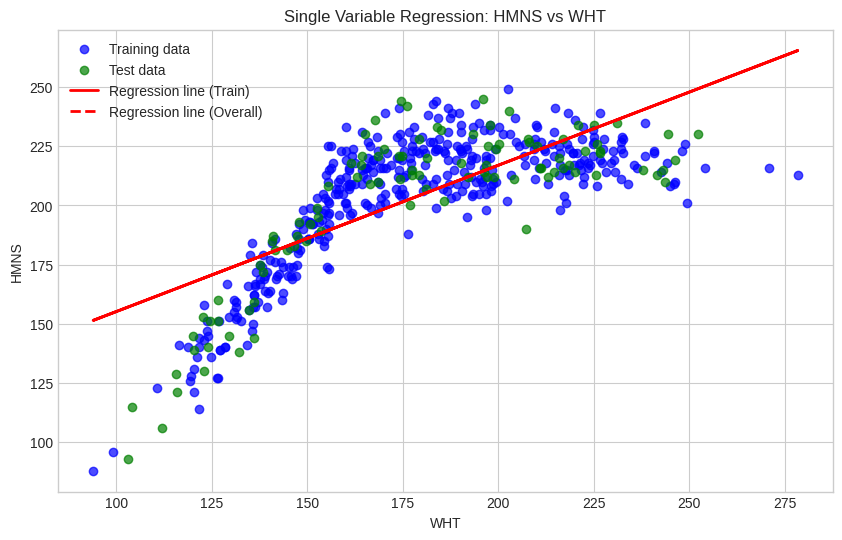

Comment on WHT model fit: The training R-squared is 0.5484 and test R-squared is 0.6091. A positive slope suggests heavier gorillas tend to beat more humans. The scatter plot shows the data distribution and the regression line's fit.


In [7]:
feature = 'WHT'
if feature in train_df.columns and not train_df[[feature, target_variable]].isnull().values.any():
    print(f"\nPerforming single variable regression for {target_variable} vs {feature}")
    model_wht, r2_train_wht, r2_test_wht, train_mse_wht, test_mse_wht = single_variable_regression_plot(train_df, test_df, feature, target_variable)
    print(f"Comment on WHT model fit: The training R-squared is {r2_train_wht:.4f} and test R-squared is {r2_test_wht:.4f}. "
          "A positive slope suggests heavier gorillas tend to beat more humans. "
          "The scatter plot shows the data distribution and the regression line's fit.")
else:
    print(f"Feature '{feature}' or target '{target_variable}' not available or contains NaNs in train_df. Skipping regression.")

## Cell 8: Single Variable Regression: HMNS vs AGE
Description: Predict HMNS using AGE. Evaluate and plot.


Performing single variable regression for HMNS vs AGE

--- HMNS vs AGE ---
Training R-squared: 0.0000
Test R-squared: -0.0038
Training MSE: 792.2453
Test MSE: 1161.4043
Model Coefficients: Intercept=202.5150, Slope=0.0150


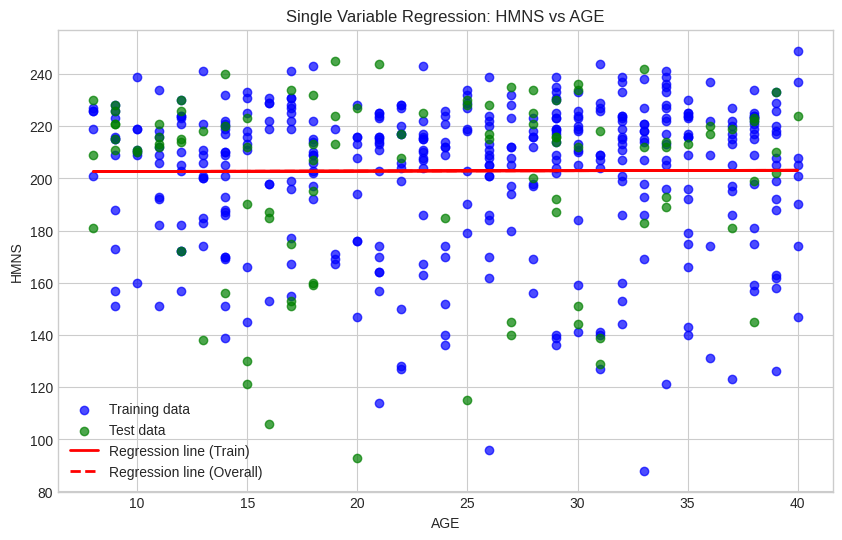

Comment on AGE model fit: The training R-squared is 0.0000 and test R-squared is -0.0038. This indicates how much variance in HMNS is explained by AGE. The plot visualizes this relationship.


In [8]:
feature = 'AGE'
if feature in train_df.columns and not train_df[[feature, target_variable]].isnull().values.any():
    print(f"\nPerforming single variable regression for {target_variable} vs {feature}")
    model_age, r2_train_age, r2_test_age, train_mse_age, test_mse_age = single_variable_regression_plot(train_df, test_df, feature, target_variable)
    print(f"Comment on AGE model fit: The training R-squared is {r2_train_age:.4f} and test R-squared is {r2_test_age:.4f}. "
          "This indicates how much variance in HMNS is explained by AGE. "
          "The plot visualizes this relationship.")
else:
    print(f"Feature '{feature}' or target '{target_variable}' not available or contains NaNs in train_df. Skipping regression.")

## Cell 9: Single Variable Regression: HMNS vs DSI
Description: Predict HMNS using DSI. Evaluate and plot.


Performing single variable regression for HMNS vs DSI

--- HMNS vs DSI ---
Training R-squared: 0.0002
Test R-squared: -0.0074
Training MSE: 792.1107
Test MSE: 1165.5158
Model Coefficients: Intercept=203.3060, Slope=-0.0020


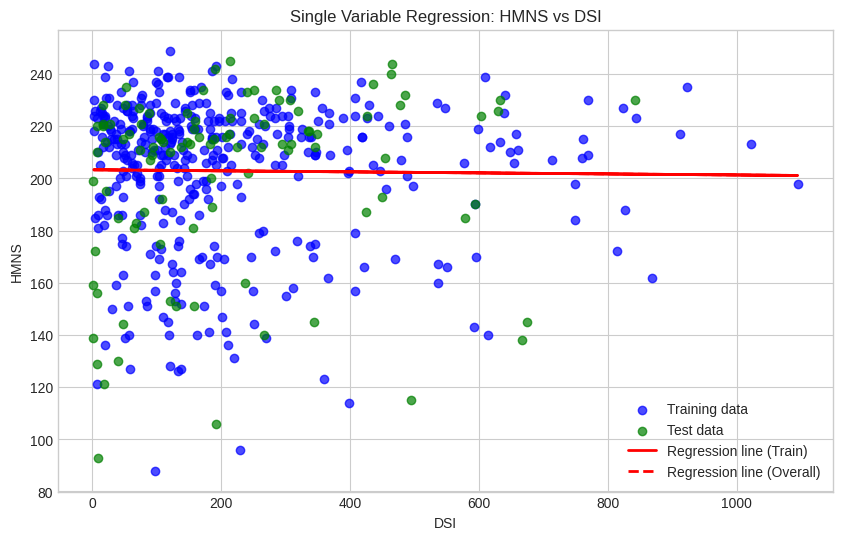

Comment on DSI model fit: The training R-squared is 0.0002 and test R-squared is -0.0074. This model assesses the impact of recent health issues on performance.


In [9]:
feature = 'DSI'
if feature in train_df.columns and not train_df[[feature, target_variable]].isnull().values.any():
    print(f"\nPerforming single variable regression for {target_variable} vs {feature}")
    model_dsi, r2_train_dsi, r2_test_dsi, train_mse_dsi, test_mse_dsi = single_variable_regression_plot(train_df, test_df, feature, target_variable)
    print(f"Comment on DSI model fit: The training R-squared is {r2_train_dsi:.4f} and test R-squared is {r2_test_dsi:.4f}. "
          "This model assesses the impact of recent health issues on performance.")
else:
    print(f"Feature '{feature}' or target '{target_variable}' not available or contains NaNs in train_df. Skipping regression.")

## Cell 10: Single Variable Regression: HMNS vs SUS
Description: Predict HMNS using SUS (sub-species). This is a categorical variable.
We'll use `statsmodels` for easier handling of categorical predictors in a single variable context.
For plotting, a boxplot or violin plot is more appropriate to show HMNS distribution per SUS.
We can also overlay mean predictions from a regression model.


--- HMNS vs SUS (Categorical) ---
                            OLS Regression Results                            
Dep. Variable:                   HMNS   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     9.162
Date:                Sat, 07 Jun 2025   Prob (F-statistic):           7.13e-06
Time:                        17:38:40   Log-Likelihood:                -1879.6
No. Observations:                 398   AIC:                             3767.
Df Residuals:                     394   BIC:                             3783.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

/tmp/ipykernel_9751/4178451660.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=feature_cat, y=target_variable, data=train_df, palette="pastel", showfliers=False) # Training data


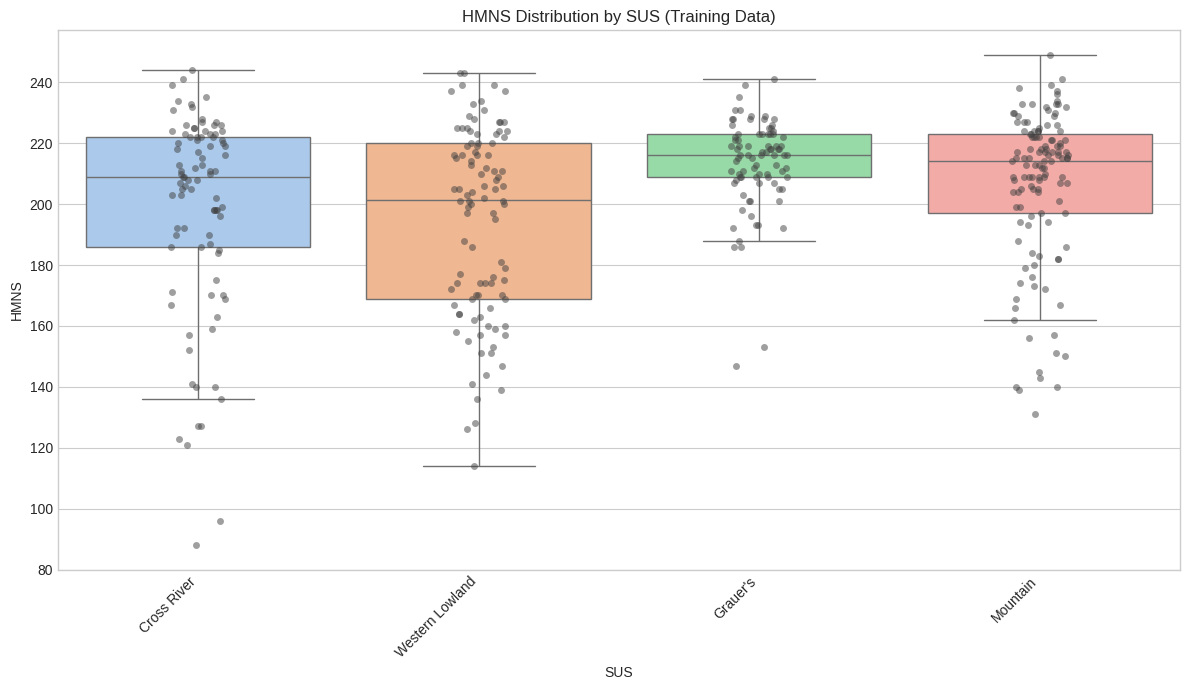

Comment on SUS model fit: The training R-squared is 0.0652. The model uses dummy variables for each sub-species. The boxplot shows the variation in HMNS across sub-species. Differences in mean HMNS per category drive the R-squared value.
The test R-squared is 0.0956.


In [10]:
feature_cat = 'SUS'
if feature_cat in train_df.columns and not train_df[[feature_cat, target_variable]].isnull().values.any():
    print(f"\n--- {target_variable} vs {feature_cat} (Categorical) ---")

    # Using statsmodels for regression with categorical variable
    formula = f'{target_variable} ~ C({feature_cat})'
    try:
        # Ensure no NaN in these specific columns for statsmodels
        ols_data_train = train_df[[target_variable, feature_cat]].dropna()
        ols_data_test = test_df[[target_variable, feature_cat]].dropna()

        model_sus_sm = smf.ols(formula, data=ols_data_train).fit()
        print(model_sus_sm.summary())

        train_r2_sus = model_sus_sm.rsquared
        print(f"Training R-squared (from statsmodels): {train_r2_sus:.4f}")

        # Predictions for test set
        if not ols_data_test.empty:
            y_test_pred_sus = model_sus_sm.predict(ols_data_test)
            test_r2_sus = r2_score(ols_data_test[target_variable], y_test_pred_sus)
            print(f"Test R-squared: {test_r2_sus:.4f}")
        else:
            test_r2_sus = float('nan') # Or handle as per requirement
            print("Test data for SUS model is empty after dropping NaNs.")


        # Plotting HMNS distribution by SUS
        plt.figure(figsize=(12, 7))
        sns.boxplot(x=feature_cat, y=target_variable, data=train_df, palette="pastel", showfliers=False) # Training data
        sns.stripplot(x=feature_cat, y=target_variable, data=train_df, color=".25", alpha=0.5, jitter=0.1)

        # Overlay mean predictions if desired (can be tricky with boxplot directly)
        # For simplicity, we'll focus on the boxplot and R-squared.
        # The "line" for a categorical predictor is essentially the mean prediction for each category.

        plt.title(f'{target_variable} Distribution by {feature_cat} (Training Data)')
        plt.xlabel(feature_cat)
        plt.ylabel(target_variable)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

        print(f"Comment on SUS model fit: The training R-squared is {train_r2_sus:.4f}. "
              "The model uses dummy variables for each sub-species. The boxplot shows the variation in HMNS across sub-species. "
              "Differences in mean HMNS per category drive the R-squared value.")
        if not np.isnan(test_r2_sus):
             print(f"The test R-squared is {test_r2_sus:.4f}.")

    except Exception as e:
        print(f"Could not fit model for {feature_cat}: {e}")
else:
    print(f"Feature '{feature_cat}' or target '{target_variable}' not available or contains NaNs in train_df. Skipping regression.")

## Cell 11: Data Preprocessing for Multiple Regression
Description: Prepare data for multiple regression models. This includes
one-hot encoding for categorical features ('SUS', 'GND') and feature scaling for numerical features.


In [11]:
# Re-identify features, ensure 'FRM' and 'GND' are included if present
all_features = ['WHT', 'AGE', 'FRM', 'DSI', 'SUS', 'GND'] # From project description
actual_cols = [col for col in all_features if col in df.columns]
numerical_features_multi = df[actual_cols].select_dtypes(include=np.number).columns.tolist()
categorical_features_multi = df[actual_cols].select_dtypes(include=['object']).columns.tolist()

print(f"\nNumerical features for multiple regression: {numerical_features_multi}")
print(f"Categorical features for multiple regression: {categorical_features_multi}")

# Define preprocessor
# Numerical features will be scaled.
# Categorical features will be one-hot encoded.
# Handle unknown categories in OHE for robustness if test set has new categories.
# Drop 'first' to avoid multicollinearity in OHE.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features_multi),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), categorical_features_multi)
    ],
    remainder='passthrough' # Keep other columns (if any) not specified, though we specify all
)

# Create a fresh train-test split for multiple regression using all available features
# First, drop rows where the target or any of the relevant features are NaN
df_multi_cleaned = df.dropna(subset=[target_variable] + actual_cols)

if not df_multi_cleaned.empty:
    X_multi = df_multi_cleaned[actual_cols]
    y_multi = df_multi_cleaned[target_variable]
    X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
        X_multi, y_multi, test_size=0.2, random_state=42
    )
    print(f"\nData split for multiple regression: Training ({len(X_train_multi)}), Testing ({len(X_test_multi)})")

    # Fit the preprocessor on training data and transform both train and test
    X_train_processed = preprocessor.fit_transform(X_train_multi)
    X_test_processed = preprocessor.transform(X_test_multi)

    # Get feature names after one-hot encoding for easier interpretation
    # Handle cases where numerical_features_multi or categorical_features_multi might be empty
    num_feature_names = numerical_features_multi if numerical_features_multi else []
    
    cat_feature_names = []
    if categorical_features_multi: # Check if there are categorical features to process
        ohe_categories = preprocessor.named_transformers_['cat'].categories_
        # Create names for OHE features, excluding the first category (due to drop='first')
        for i, cat_feat in enumerate(categorical_features_multi):
            if len(ohe_categories[i]) > 1: # Ensure there's more than one category to drop
                 cat_feature_names.extend([f"{cat_feat}_{cat}" for cat in ohe_categories[i][1:]])
            # If only one category, it might be dropped or handled differently by OHE.
            # This simple naming assumes multiple categories and drop='first'.

    processed_feature_names = num_feature_names + cat_feature_names
    
    # Convert processed arrays back to DataFrames (optional, but good for inspection)
    X_train_processed_df = pd.DataFrame(X_train_processed, columns=processed_feature_names, index=X_train_multi.index)
    X_test_processed_df = pd.DataFrame(X_test_processed, columns=processed_feature_names, index=X_test_multi.index)

    print("\nProcessed training data (first 5 rows):")
    print(X_train_processed_df.head())

else:
    print("DataFrame for multiple regression is empty after dropping NaNs. Cannot proceed with multiple regression.")
    # Create dummy processed data to allow rest of notebook to run structurally
    X_train_processed_df = pd.DataFrame()
    X_test_processed_df = pd.DataFrame()
    y_train_multi = pd.Series()
    y_test_multi = pd.Series()


Numerical features for multiple regression: ['WHT', 'AGE', 'FRM', 'DSI']
Categorical features for multiple regression: ['SUS', 'GND']

Data split for multiple regression: Training (398), Testing (100)

Processed training data (first 5 rows):
          WHT       AGE       FRM       DSI  SUS_Grauer's  SUS_Mountain  \
57  -1.647886  0.435973 -1.650771 -0.774864           0.0           0.0   
229 -1.553047 -0.109336 -1.120242 -0.967209           0.0           0.0   
282 -0.761727  1.090343  0.011553 -0.542024           1.0           0.0   
487  1.754492  0.326911  1.921456  1.052419           0.0           0.0   
222 -1.378186  0.763158 -0.766556  1.654764           0.0           0.0   

     SUS_Western Lowland  GND_Male  
57                   0.0       0.0  
229                  1.0       0.0  
282                  0.0       0.0  
487                  1.0       1.0  
222                  1.0       0.0  


## Cell 12: Multiple Variable Regression - Model 1 (All available features)
Description: Build a multiple linear regression model using all preprocessed features.
Evaluate its performance and plot errors.


--- Multiple Regression Model 1: All Features ---
Training R-squared: 0.5563
Test R-squared: 0.6104
Training MSE: 351.5491
Test MSE: 450.7138
Training MAE: 15.3289
Test MAE: 16.6056

Model Coefficients:
WHT                    21.648712
SUS_Mountain            3.252989
SUS_Western Lowland     2.975613
DSI                     1.669229
GND_Male                1.305859
SUS_Grauer's           -0.194436
AGE                    -0.431107
FRM                    -1.237833
dtype: float64


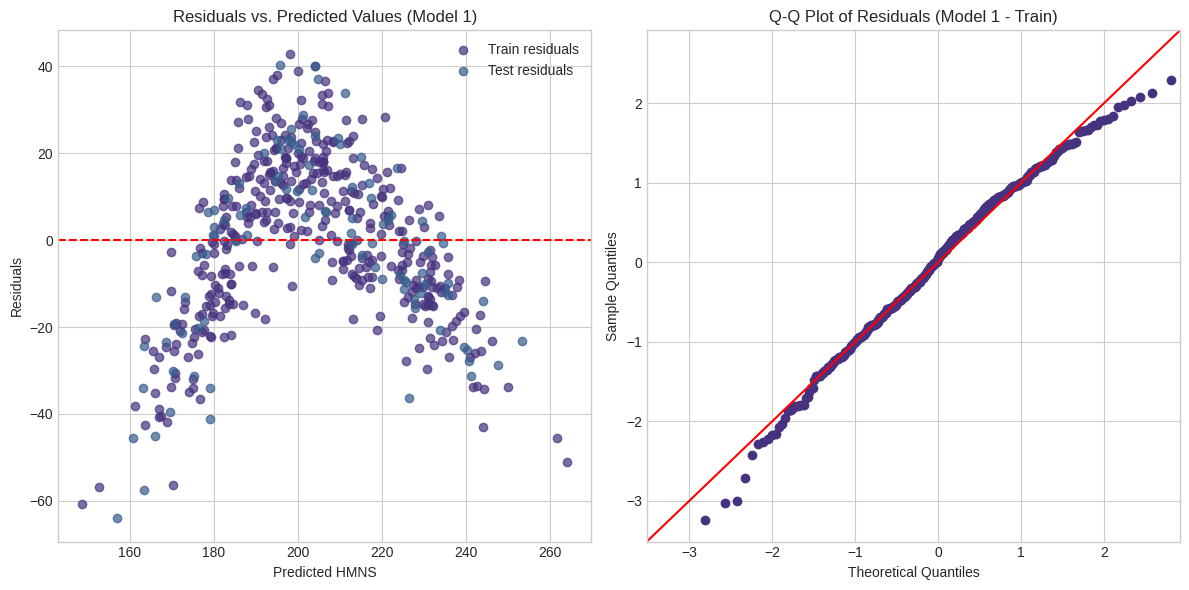

In [12]:
model_multi_1_coeffs = [] # To store coefficients later

if not X_train_processed_df.empty:
    print("\n--- Multiple Regression Model 1: All Features ---")
    model_multi_1 = LinearRegression()
    model_multi_1.fit(X_train_processed_df, y_train_multi)

    # Predictions
    y_train_pred_multi_1 = model_multi_1.predict(X_train_processed_df)
    y_test_pred_multi_1 = model_multi_1.predict(X_test_processed_df)

    # Evaluation
    train_r2_multi_1 = r2_score(y_train_multi, y_train_pred_multi_1)
    test_r2_multi_1 = r2_score(y_test_multi, y_test_pred_multi_1)
    train_mse_multi_1 = mean_squared_error(y_train_multi, y_train_pred_multi_1)
    test_mse_multi_1 = mean_squared_error(y_test_multi, y_test_pred_multi_1)
    train_mae_multi_1 = mean_absolute_error(y_train_multi, y_train_pred_multi_1)
    test_mae_multi_1 = mean_absolute_error(y_test_multi, y_test_pred_multi_1)

    print(f"Training R-squared: {train_r2_multi_1:.4f}")
    print(f"Test R-squared: {test_r2_multi_1:.4f}")
    print(f"Training MSE: {train_mse_multi_1:.4f}")
    print(f"Test MSE: {test_mse_multi_1:.4f}")
    print(f"Training MAE: {train_mae_multi_1:.4f}")
    print(f"Test MAE: {test_mae_multi_1:.4f}")

    model_multi_1_coeffs = pd.Series(model_multi_1.coef_, index=X_train_processed_df.columns)
    print("\nModel Coefficients:")
    print(model_multi_1_coeffs.sort_values(ascending=False))

    # Plotting Errors: Residuals vs. Predicted values
    residuals_train = y_train_multi - y_train_pred_multi_1
    residuals_test = y_test_multi - y_test_pred_multi_1

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(y_train_pred_multi_1, residuals_train, alpha=0.7, label='Train residuals')
    plt.scatter(y_test_pred_multi_1, residuals_test, alpha=0.7, label='Test residuals')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted HMNS')
    plt.ylabel('Residuals')
    plt.title('Residuals vs. Predicted Values (Model 1)')
    plt.legend()

    # Q-Q plot for residuals (using training residuals for normality check)
    plt.subplot(1, 2, 2)
    sm.qqplot(residuals_train, line='45', fit=True, ax=plt.gca())
    plt.title('Q-Q Plot of Residuals (Model 1 - Train)')
    
    plt.tight_layout()
    plt.show()
else:
    print("Skipping Multiple Regression Model 1 due to empty processed training data.")

## Cell 13: Multiple Variable Regression - Model Building Iterations (e.g., Feature Selection)
Description: Try different combinations of features or use feature selection techniques
like Recursive Feature Elimination (RFE).


--- Multiple Regression Model 2: RFE Feature Selection ---
Selected features by RFE (4 features): ['WHT', 'DSI', 'SUS_Mountain', 'SUS_Western Lowland']
Training R-squared (RFE): 0.5550
Test R-squared (RFE): 0.6122
Training MSE (RFE): 352.5964
Test MSE (RFE): 448.6721

Model Coefficients (RFE):
WHT                    21.303474
SUS_Mountain            3.250224
SUS_Western Lowland     3.233273
DSI                     1.614184
dtype: float64


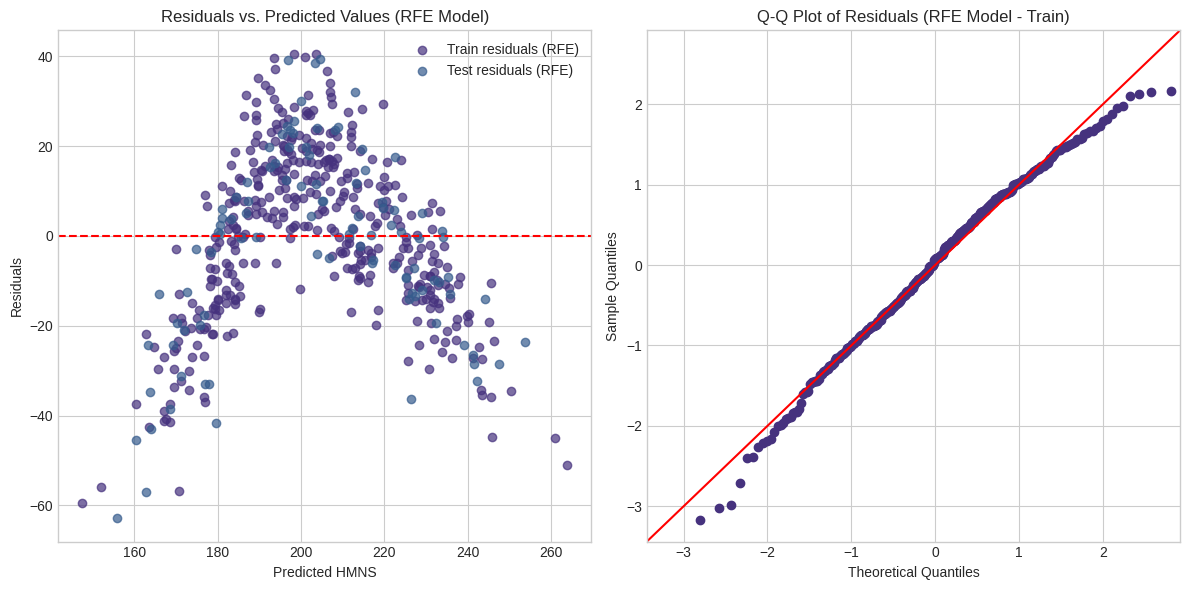

Comment on model selection: Model 1 (all features) and Model 2 (RFE) can be compared based on their test R-squared and MSE. A simpler model (RFE) might be preferred if its performance is comparable, to avoid overfitting and improve interpretability. Other criteria like AIC/BIC can also be used.


In [13]:
model_multi_2_coeffs = []

if not X_train_processed_df.empty:
    print("\n--- Multiple Regression Model 2: RFE Feature Selection ---")
    # Using RFE to select, for example, half of the features
    num_features_to_select = max(1, X_train_processed_df.shape[1] // 2) # Ensure at least 1 feature
    
    estimator = LinearRegression()
    selector_rfe = RFE(estimator, n_features_to_select=num_features_to_select, step=1)
    selector_rfe = selector_rfe.fit(X_train_processed_df, y_train_multi)

    selected_features_rfe = X_train_processed_df.columns[selector_rfe.support_]
    print(f"Selected features by RFE ({num_features_to_select} features): {selected_features_rfe.tolist()}")

    X_train_rfe = X_train_processed_df[selected_features_rfe]
    X_test_rfe = X_test_processed_df[selected_features_rfe]

    model_multi_2 = LinearRegression()
    model_multi_2.fit(X_train_rfe, y_train_multi)

    # Predictions
    y_train_pred_multi_2 = model_multi_2.predict(X_train_rfe)
    y_test_pred_multi_2 = model_multi_2.predict(X_test_rfe)

    # Evaluation
    train_r2_multi_2 = r2_score(y_train_multi, y_train_pred_multi_2)
    test_r2_multi_2 = r2_score(y_test_multi, y_test_pred_multi_2)
    train_mse_multi_2 = mean_squared_error(y_train_multi, y_train_pred_multi_2)
    test_mse_multi_2 = mean_squared_error(y_test_multi, y_test_pred_multi_2)

    print(f"Training R-squared (RFE): {train_r2_multi_2:.4f}")
    print(f"Test R-squared (RFE): {test_r2_multi_2:.4f}")
    print(f"Training MSE (RFE): {train_mse_multi_2:.4f}")
    print(f"Test MSE (RFE): {test_mse_multi_2:.4f}")

    model_multi_2_coeffs = pd.Series(model_multi_2.coef_, index=selected_features_rfe)
    print("\nModel Coefficients (RFE):")
    print(model_multi_2_coeffs.sort_values(ascending=False))
    
    # Plotting Errors for RFE model
    residuals_train_rfe = y_train_multi - y_train_pred_multi_2
    residuals_test_rfe = y_test_multi - y_test_pred_multi_2

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(y_train_pred_multi_2, residuals_train_rfe, alpha=0.7, label='Train residuals (RFE)')
    plt.scatter(y_test_pred_multi_2, residuals_test_rfe, alpha=0.7, label='Test residuals (RFE)')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted HMNS')
    plt.ylabel('Residuals')
    plt.title('Residuals vs. Predicted Values (RFE Model)')
    plt.legend()

    plt.subplot(1, 2, 2)
    sm.qqplot(residuals_train_rfe, line='45', fit=True, ax=plt.gca())
    plt.title('Q-Q Plot of Residuals (RFE Model - Train)')
    
    plt.tight_layout()
    plt.show()

    print("Comment on model selection: Model 1 (all features) and Model 2 (RFE) can be compared based on their test R-squared and MSE. "
          "A simpler model (RFE) might be preferred if its performance is comparable, to avoid overfitting and improve interpretability. "
          "Other criteria like AIC/BIC can also be used.")
else:
    print("Skipping Multiple Regression Model 2 (RFE) due to empty processed training data.")

## Cell 14: Model Comparison (Metrics Summary)
Description: Summarize performance metrics (R-squared, MSE) for all fitted models.
Discuss improvements.

In [14]:
print("\n--- Model Comparison Summary ---")
results = []
# Single Variable Models (example structure, assuming variables were stored)
if 'r2_train_wht' in locals(): results.append({'Model': 'WHT (Single Var)', 'Train R2': r2_train_wht, 'Test R2': r2_test_wht, 'Train MSE': locals().get('train_mse_wht', np.nan), 'Test MSE': locals().get('test_mse_wht', np.nan)})
if 'r2_train_age' in locals(): results.append({'Model': 'AGE (Single Var)', 'Train R2': r2_train_age, 'Test R2': r2_test_age, 'Train MSE': locals().get('train_mse_age', np.nan), 'Test MSE': locals().get('test_mse_age', np.nan)})
if 'r2_train_dsi' in locals(): results.append({'Model': 'DSI (Single Var)', 'Train R2': r2_train_dsi, 'Test R2': r2_test_dsi, 'Train MSE': locals().get('train_mse_dsi', np.nan), 'Test MSE': locals().get('test_mse_dsi', np.nan)})
if 'train_r2_sus' in locals(): results.append({'Model': 'SUS (Single Var - statsmodels)', 'Train R2': train_r2_sus, 'Test R2': locals().get('test_r2_sus', np.nan), 'Train MSE': np.nan, 'Test MSE': np.nan}) # MSE not directly from summary

# Multiple Variable Models
if 'train_r2_multi_1' in locals(): results.append({'Model': 'Multiple (All Features)', 'Train R2': train_r2_multi_1, 'Test R2': test_r2_multi_1, 'Train MSE': train_mse_multi_1, 'Test MSE': test_mse_multi_1})
if 'train_r2_multi_2' in locals(): results.append({'Model': 'Multiple (RFE Features)', 'Train R2': train_r2_multi_2, 'Test R2': test_r2_multi_2, 'Train MSE': train_mse_multi_2, 'Test MSE': test_mse_multi_2})

if results:
    results_df = pd.DataFrame(results)
    print(results_df.to_string()) # Print full DataFrame

    print("\nDiscussion on Model Improvement:")
    print("Generally, multiple regression models are expected to outperform single variable models "
          "if the additional features provide relevant information and multicollinearity is managed. "
          "Compare Test R2 and Test MSE: higher Test R2 and lower Test MSE indicate better generalization. "
          "The RFE model might improve over the 'all features' model if it removes noisy or irrelevant features, "
          "leading to better test performance or a more parsimonious model.")
else:
    print("No model results to display for comparison.")


--- Model Comparison Summary ---
                            Model  Train R2   Test R2   Train MSE     Test MSE
0                WHT (Single Var)  0.548425  0.609141  357.766840   452.216430
1                AGE (Single Var)  0.000024 -0.003823  792.245304  1161.404308
2                DSI (Single Var)  0.000194 -0.007376  792.110679  1165.515841
3  SUS (Single Var - statsmodels)  0.065214  0.095608         NaN          NaN
4         Multiple (All Features)  0.556273  0.610440  351.549127   450.713784
5         Multiple (RFE Features)  0.554951  0.612205  352.596426   448.672110

Discussion on Model Improvement:
Generally, multiple regression models are expected to outperform single variable models if the additional features provide relevant information and multicollinearity is managed. Compare Test R2 and Test MSE: higher Test R2 and lower Test MSE indicate better generalization. The RFE model might improve over the 'all features' model if it removes noisy or irrelevant features, lea

## Cell 15: Interpretability
Description: Discuss the coefficients of the best multiple regression model.
Do they make sense in the context of gorilla tug-of-war?

In [15]:
print("\n--- Model Interpretability ---")
# Assuming Model 1 (all features) or Model 2 (RFE) is chosen as 'best' for now.
# Let's pick Model 1 for this example if it exists, otherwise Model 2.
best_multi_model_coeffs = None
best_model_name = ""

if 'model_multi_1_coeffs' in locals() and not model_multi_1_coeffs.empty:
    # Heuristic: choose model with higher test R2 if both exist
    if 'test_r2_multi_2' in locals() and test_r2_multi_2 > test_r2_multi_1:
        if not model_multi_2_coeffs.empty:
            best_multi_model_coeffs = model_multi_2_coeffs
            best_model_name = "Multiple (RFE Features)"
            print("Interpreting RFE Model (Model 2) due to potentially better/comparable test performance.")
        else: # Fallback if RFE coeffs somehow not populated
            best_multi_model_coeffs = model_multi_1_coeffs
            best_model_name = "Multiple (All Features)"
            print("Interpreting All Features Model (Model 1).")

    else:
        best_multi_model_coeffs = model_multi_1_coeffs
        best_model_name = "Multiple (All Features)"
        print("Interpreting All Features Model (Model 1).")

elif 'model_multi_2_coeffs' in locals() and not model_multi_2_coeffs.empty:
    best_multi_model_coeffs = model_multi_2_coeffs
    best_model_name = "Multiple (RFE Features)"
    print("Interpreting RFE Model (Model 2) as Model 1 results are not available.")
else:
    print("No multiple regression model coefficients to interpret.")


if best_multi_model_coeffs is not None:
    print(f"\nCoefficients for {best_model_name}:")
    print(best_multi_model_coeffs.sort_values(ascending=False))
    print("\nDiscussion on Interpretability:")
    print("Interpret coefficients considering they are from scaled numerical data and one-hot encoded categoricals.")
    print("- Positive coefficient for WHT: Expected, as heavier gorillas might be stronger.")
    print("- Coefficient for AGE: Could be positive (experience) or negative (older, weaker), or non-linear (prime age).")
    print("- Positive coefficient for FRM: Expected, larger forearm circumference might indicate more muscle.")
    print("- Coefficient for DSI: Expected to be positive if a longer time since illness means better health and strength.")
    print("- Coefficients for SUS categories: Indicate how each sub-species compares to the baseline category in predicting HMNS, holding other factors constant.")
    print("- Coefficients for GND categories: Indicate how gender (e.g., Male vs Female baseline) impacts HMNS.")
    print("The actual signs and magnitudes from your model should be examined. If a coefficient is counter-intuitive (e.g., WHT is negative), "
          "it could be due to multicollinearity, insufficient data, or other complex interactions not captured by the linear model.")
else:
    print("Interpretability discussion skipped as no model coefficients are available.")


--- Model Interpretability ---
Interpreting RFE Model (Model 2) due to potentially better/comparable test performance.

Coefficients for Multiple (RFE Features):
WHT                    21.303474
SUS_Mountain            3.250224
SUS_Western Lowland     3.233273
DSI                     1.614184
dtype: float64

Discussion on Interpretability:
Interpret coefficients considering they are from scaled numerical data and one-hot encoded categoricals.
- Positive coefficient for WHT: Expected, as heavier gorillas might be stronger.
- Coefficient for AGE: Could be positive (experience) or negative (older, weaker), or non-linear (prime age).
- Positive coefficient for FRM: Expected, larger forearm circumference might indicate more muscle.
- Coefficient for DSI: Expected to be positive if a longer time since illness means better health and strength.
- Coefficients for SUS categories: Indicate how each sub-species compares to the baseline category in predicting HMNS, holding other factors constant.

## Cell 16: Model Evaluation (Advanced) - Cross-Validation and AIC/BIC
Description: Use cross-validation for more robust evaluation.
Calculate AIC/BIC for model selection (using statsmodels for easier AIC/BIC).

In [16]:
if not X_train_processed_df.empty and 'model_multi_1' in locals(): # Using Model 1 as example
    print("\n--- Advanced Model Evaluation: Cross-Validation (Model 1) ---")
    # Cross-validation for the 'all features' multiple regression model
    cv_scores_r2 = cross_val_score(model_multi_1, X_train_processed_df, y_train_multi, cv=5, scoring='r2')
    cv_scores_mse = cross_val_score(model_multi_1, X_train_processed_df, y_train_multi, cv=5, scoring='neg_mean_squared_error')

    print(f"Cross-validation R2 scores: {cv_scores_r2}")
    print(f"Mean CV R2 score: {np.mean(cv_scores_r2):.4f} (+/- {np.std(cv_scores_r2):.4f})")
    print(f"Cross-validation MSE scores (negative): {cv_scores_mse}")
    print(f"Mean CV MSE score: {-np.mean(cv_scores_mse):.4f} (+/- {np.std(cv_scores_mse):.4f})")

    # AIC/BIC using statsmodels
    # Need to add a constant for statsmodels OLS if not already done by scaling (StandardScaler doesn't add intercept term to X)
    X_train_sm = sm.add_constant(X_train_processed_df) # Add intercept
    model_sm_multi_1 = sm.OLS(y_train_multi, X_train_sm).fit()
    print("\nStatsmodels OLS summary for Model 1 (All Features) - for AIC/BIC:")
    print(model_sm_multi_1.summary())
    print(f"AIC for Model 1: {model_sm_multi_1.aic:.2f}")
    print(f"BIC for Model 1: {model_sm_multi_1.bic:.2f}")

    # For RFE model (Model 2) if it exists
    if 'model_multi_2' in locals() and not X_train_rfe.empty:
        X_train_rfe_sm = sm.add_constant(X_train_rfe)
        model_sm_multi_2 = sm.OLS(y_train_multi, X_train_rfe_sm).fit()
        print("\nStatsmodels OLS summary for Model 2 (RFE Features) - for AIC/BIC:")
        print(model_sm_multi_2.summary())
        print(f"AIC for Model 2: {model_sm_multi_2.aic:.2f}")
        print(f"BIC for Model 2: {model_sm_multi_2.bic:.2f}")
        print("\nAIC/BIC help in model selection: lower values are preferred, balancing fit and complexity.")
else:
    print("Skipping Advanced Model Evaluation due to missing data or models.")


--- Advanced Model Evaluation: Cross-Validation (Model 1) ---
Cross-validation R2 scores: [0.59989409 0.54674964 0.54651893 0.34872453 0.51333642]
Mean CV R2 score: 0.5110 (+/- 0.0858)
Cross-validation MSE scores (negative): [-401.88612644 -408.69131864 -283.85761201 -367.15177    -412.3293665 ]
Mean CV MSE score: 374.7832 (+/- 48.2074)

Statsmodels OLS summary for Model 1 (All Features) - for AIC/BIC:
                            OLS Regression Results                            
Dep. Variable:                   HMNS   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     60.96
Date:                Sat, 07 Jun 2025   Prob (F-statistic):           5.10e-64
Time:                        17:38:41   Log-Likelihood:                -1731.3
No. Observations:                 398   AIC:                             3481.
Df Residuals:                     389   

## Cell 17: Feature Engineering
Description: Create new features from existing ones to potentially improve model performance.
Examples: Interaction terms, polynomial features.


--- Feature Engineering ---
Engineered feature: WHT_x_FRM
Engineered feature: AGE_sq
Engineered feature: WHT_per_AGE

Processed training data with engineered features (first 5 rows):
          WHT       AGE       FRM       DSI  WHT_x_FRM    AGE_sq  WHT_per_AGE  \
57  -1.647886  0.435973 -1.650771 -0.774864  -1.513005  0.290791    -0.932296   
229 -1.553047 -0.109336 -1.120242 -0.967209  -1.262725 -0.293873    -0.713520   
282 -0.761727  1.090343  0.011553 -0.542024  -0.420442  1.138001    -0.902861   
487  1.754492  0.326911  1.921456  1.052419   2.265857  0.165033    -0.008921   
222 -1.378186  0.763158 -0.766556  1.654764  -1.048283  0.694540    -0.955920   

     SUS_Grauer's  SUS_Mountain  SUS_Western Lowland  GND_Male  
57            0.0           0.0                  0.0       0.0  
229           0.0           0.0                  1.0       0.0  
282           1.0           0.0                  0.0       0.0  
487           0.0           0.0                  1.0       1.0  
222 

/tmp/ipykernel_9751/1650846822.py:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Test R2', y='Model', data=results_df.sort_values('Test R2', ascending=False), palette='viridis')


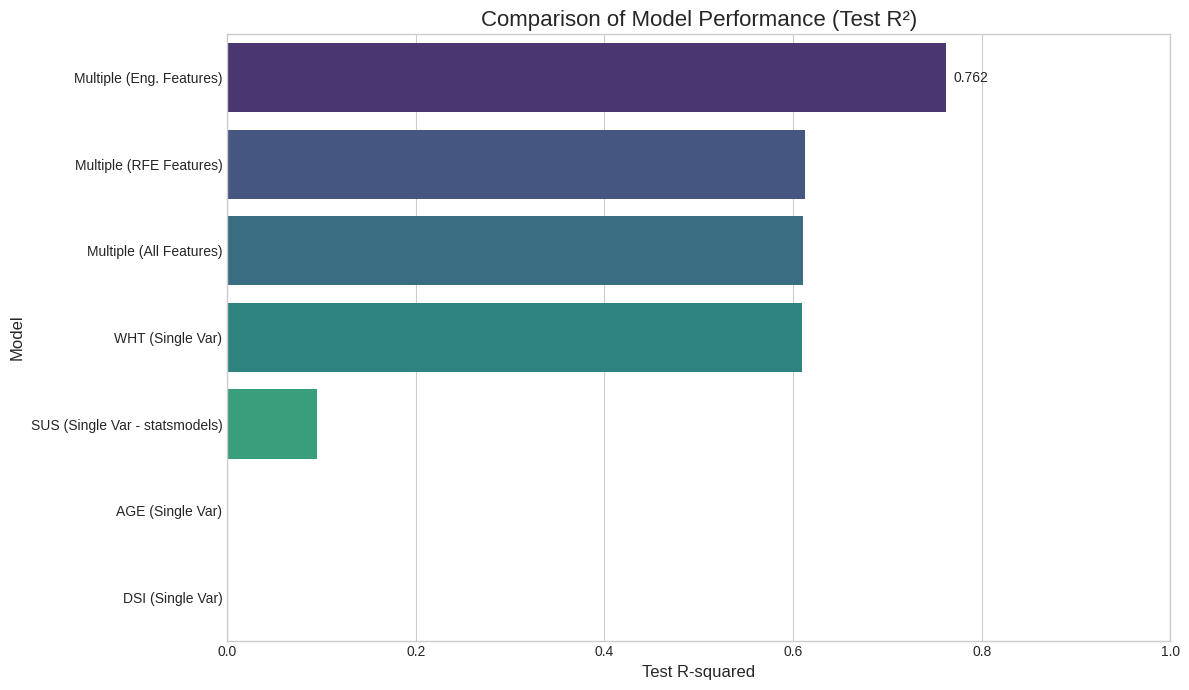

In [ ]:
print("\n--- Feature Engineering ---")
# Make sure to use the original (pre-split, pre-processed) training data for creating features
# to avoid data leakage if transformations depend on data distributions.
# However, for simplicity here, we'll demonstrate on X_train_multi (unprocessed features from the multi-regression split).

if not X_train_multi.empty:
    X_train_eng = X_train_multi.copy()
    X_test_eng = X_test_multi.copy()

    # Example 1: Interaction term (WHT * FRM) - ensure these columns exist
    if 'WHT' in X_train_eng.columns and 'FRM' in X_train_eng.columns:
        X_train_eng['WHT_x_FRM'] = X_train_eng['WHT'] * X_train_eng['FRM']
        X_test_eng['WHT_x_FRM'] = X_test_eng['WHT'] * X_test_eng['FRM']
        print("Engineered feature: WHT_x_FRM")

    # Example 2: Polynomial feature for AGE (AGE^2)
    if 'AGE' in X_train_eng.columns:
        X_train_eng['AGE_sq'] = X_train_eng['AGE']**2
        X_test_eng['AGE_sq'] = X_test_eng['AGE']**2
        print("Engineered feature: AGE_sq")
    
    # Example 3: Ratio WHT/AGE
    if 'WHT' in X_train_eng.columns and 'AGE' in X_train_eng.columns:
        # Avoid division by zero if AGE can be 0
        X_train_eng['WHT_per_AGE'] = X_train_eng['WHT'] / (X_train_eng['AGE'] + 1e-6)
        X_test_eng['WHT_per_AGE'] = X_test_eng['WHT'] / (X_test_eng['AGE'] + 1e-6)
        print("Engineered feature: WHT_per_AGE")


    # Update numerical and categorical feature lists for the new preprocessor
    numerical_features_eng = X_train_eng.select_dtypes(include=np.number).columns.tolist()
    categorical_features_eng = X_train_eng.select_dtypes(include=['object']).columns.tolist()

    preprocessor_eng = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features_eng),
            ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), categorical_features_eng)
        ],
        remainder='passthrough'
    )

    X_train_eng_processed = preprocessor_eng.fit_transform(X_train_eng)
    X_test_eng_processed = preprocessor_eng.transform(X_test_eng)
    
    # Get feature names for the engineered set
    num_feature_names_eng = numerical_features_eng
    cat_feature_names_eng = []
    if categorical_features_eng: # Check if there are categorical features to process
        ohe_categories_eng = preprocessor_eng.named_transformers_['cat'].categories_
        for i, cat_feat in enumerate(categorical_features_eng):
            if len(ohe_categories_eng[i]) > 1:
                 cat_feature_names_eng.extend([f"{cat_feat}_{cat}" for cat in ohe_categories_eng[i][1:]])
    
    processed_feature_names_eng = num_feature_names_eng + cat_feature_names_eng
    
    X_train_eng_processed_df = pd.DataFrame(X_train_eng_processed, columns=processed_feature_names_eng, index=X_train_eng.index)
    X_test_eng_processed_df = pd.DataFrame(X_test_eng_processed, columns=processed_feature_names_eng, index=X_test_eng.index)


    print("\nProcessed training data with engineered features (first 5 rows):")
    print(X_train_eng_processed_df.head())

    # Re-train a model with these engineered features
    print("\n--- Multiple Regression Model 3: With Engineered Features ---")
    model_multi_3 = LinearRegression()
    model_multi_3.fit(X_train_eng_processed_df, y_train_multi)

    # Predictions
    y_train_pred_multi_3 = model_multi_3.predict(X_train_eng_processed_df)
    y_test_pred_multi_3 = model_multi_3.predict(X_test_eng_processed_df)

    # Evaluation
    train_r2_multi_3 = r2_score(y_train_multi, y_train_pred_multi_3)
    test_r2_multi_3 = r2_score(y_test_multi, y_test_pred_multi_3)
    train_mse_multi_3 = mean_squared_error(y_train_multi, y_train_pred_multi_3)
    test_mse_multi_3 = mean_squared_error(y_test_multi, y_test_pred_multi_3)

    print(f"Training R-squared (Eng. Features): {train_r2_multi_3:.4f}")
    print(f"Test R-squared (Eng. Features): {test_r2_multi_3:.4f}")
    print(f"Training MSE (Eng. Features): {train_mse_multi_3:.4f}")
    print(f"Test MSE (Eng. Features): {test_mse_multi_3:.4f}")

    model_multi_3_coeffs = pd.Series(model_multi_3.coef_, index=X_train_eng_processed_df.columns)
    print("\nModel Coefficients (Eng. Features):")
    print(model_multi_3_coeffs.sort_values(ascending=False))

    print("\nExplanation of engineered features:")
    print("- WHT_x_FRM: This interaction term was chosen because the effect of weight might depend on forearm size (or vice-versa). Stronger gorillas might be both heavy and have large forearms.")
    print("- AGE_sq: Age might have a non-linear relationship with strength (e.g., strength peaks at a certain age and then declines). A quadratic term can capture this.")
    print("- WHT_per_AGE: This could represent a 'prime' condition, where a gorilla has high weight for its age.")
    print("Compare the performance (Test R2, MSE, AIC/BIC) of this model with previous ones to see if feature engineering helped.")

    # Add to results DataFrame
    if 'results_df' in locals() and isinstance(results_df, pd.DataFrame):
        new_row = {'Model': 'Multiple (Eng. Features)', 'Train R2': train_r2_multi_3, 'Test R2': test_r2_multi_3, 'Train MSE': train_mse_multi_3, 'Test MSE': test_mse_multi_3}
        results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)
        print("\nUpdated Model Comparison Summary:")
        print(results_df.to_string())
    else: # If results_df was not created due to earlier skips
        results = [{'Model': 'Multiple (Eng. Features)', 'Train R2': train_r2_multi_3, 'Test R2': test_r2_multi_3, 'Train MSE': train_mse_multi_3, 'Test MSE': test_mse_multi_3}]
        results_df = pd.DataFrame(results)
        print("\nModel Comparison Summary (with Eng. Features):")
        print(results_df.to_string())

    plt.figure(figsize=(12, 7))

    ax = sns.barplot(x='Test R2', y='Model', data=results_df.sort_values('Test R2', ascending=False), palette='viridis')

    ax.bar_label(ax.containers[0], fmt='%.3f', padding=5)

    plt.title('Comparison of Model Performance (Test R²)', fontsize=16)
    plt.xlabel('Test R-squared', fontsize=12)
    plt.ylabel('Model', fontsize=12)
    plt.xlim(0, 1.0) 
    plt.tight_layout()

    plt.savefig('R2_comparison_barchart.png', dpi=300)

    plt.show()

else:
    print("Skipping Feature Engineering due to empty X_train_multi.")

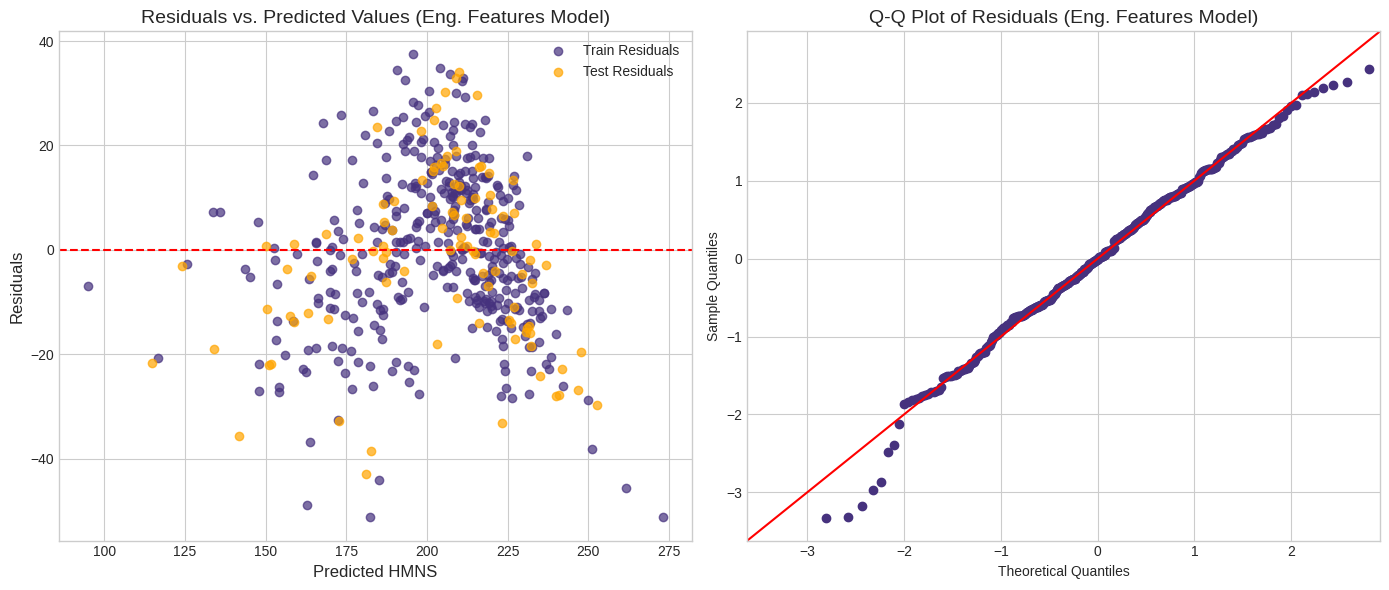

In [ ]:
# Plotting Errors for the Engineered Features model (Model 3)
# First, calculate the residuals for the training data
residuals_train_eng = y_train_multi - y_train_pred_multi_3

plt.figure(figsize=(14, 6))

# Subplot 1: Residuals vs. Predicted Values
plt.subplot(1, 2, 1)
# Plot training residuals
plt.scatter(y_train_pred_multi_3, residuals_train_eng, alpha=0.7, label='Train Residuals')
# Plot testing residuals
if 'y_test_pred_multi_3' in locals(): # Check if test predictions exist
    residuals_test_eng = y_test_multi - y_test_pred_multi_3
    plt.scatter(y_test_pred_multi_3, residuals_test_eng, alpha=0.7, label='Test Residuals', color='orange')

plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs. Predicted Values (Eng. Features Model)', fontsize=14)
plt.xlabel('Predicted HMNS', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.legend()
plt.grid(True)

# Subplot 2: Q-Q Plot
plt.subplot(1, 2, 2)
sm.qqplot(residuals_train_eng, line='45', fit=True, ax=plt.gca())
plt.title('Q-Q Plot of Residuals (Eng. Features Model)', fontsize=14)

plt.tight_layout()


# fig, ax = plt.subplots(figsize=(7,5))
# ax.scatter(y_train_pred_multi_3, residuals_train_eng, alpha=0.7)
# ax.axhline(y=0, color='r', linestyle='--')
# ax.set_title('Residuals vs. Predicted Values (Eng. Features Model)')
# ax.set_xlabel('Predicted HMNS')
# ax.set_ylabel('Residuals')
# fig.savefig('residuals_vs_predicted_plot.png', dpi=300)

# fig, ax = plt.subplots(figsize=(7,5))
# sm.qqplot(residuals_train_eng, line='45', fit=True, ax=ax)
# ax.set_title('Q-Q Plot of Residuals (Eng. Features Model)')
# fig.savefig('qq_plot.png', dpi=300)


plt.show()

## Cell 18: Final Model Selection and Conclusion
Description: Based on all evaluations, select the 'best' model and summarize findings.

In [19]:
print("\n--- Final Model Selection and Conclusion ---")
print("To select the best model, consider the following:")
print("1. Test R-squared: Higher is better.")
print("2. Test MSE/RMSE: Lower is better.")
print("3. AIC/BIC (if calculated): Lower is better, balancing fit and complexity.")
print("4. Parsimony: Simpler models are often preferred if performance is similar to complex ones.")
print("5. Interpretability: Does the model make sense in the given context?")
print("6. Cross-validation scores: Indicate robustness of the model.")
print("\nBased on the 'results_df' and AIC/BIC values (if available), make a final choice.")
print("For instance, if the 'Engineered Features' model shows significantly better test R-squared and lower MSE/AIC/BIC "
      "without being overly complex, it might be the preferred model.")
print("The project requires you to justify your choice. Ensure your chosen model's assumptions (e.g., linearity, "
      "homoscedasticity of residuals, normality of residuals) are reasonably met by checking the diagnostic plots.")


--- Final Model Selection and Conclusion ---
To select the best model, consider the following:
1. Test R-squared: Higher is better.
2. Test MSE/RMSE: Lower is better.
3. AIC/BIC (if calculated): Lower is better, balancing fit and complexity.
4. Parsimony: Simpler models are often preferred if performance is similar to complex ones.
5. Interpretability: Does the model make sense in the given context?
6. Cross-validation scores: Indicate robustness of the model.

Based on the 'results_df' and AIC/BIC values (if available), make a final choice.
For instance, if the 'Engineered Features' model shows significantly better test R-squared and lower MSE/AIC/BIC without being overly complex, it might be the preferred model.
The project requires you to justify your choice. Ensure your chosen model's assumptions (e.g., linearity, homoscedasticity of residuals, normality of residuals) are reasonably met by checking the diagnostic plots.
